# Project: Hungarian Chickenpox Cases Forecasting

Abstract: A spatio-temporal dataset of weekly chickenpox cases from Hungary. The dataset consists of a county-level adjacency matrix and time series of the county-level reported cases between 2005 and 2015.

# About the datases:

link to hte dataset at UCI: https://archive.ics.uci.edu/ml/datasets/Hungarian+Chickenpox+Cases

Data Set Characteristics: Time-Series

Number of Instances: 521

Area: Life

Attribute Characteristics: Real

Number of Attributes: 20

Date Donated 2021-02-17

Associated Tasks: Regression

Missing Values? N/A

Number of Web Hits: 24976

## Source:

Benedek Rozemberczki, The University of Edinburgh, benedek.rozemberczki '@' gmail.com

## Data Set Information:

A spatio-temporal dataset of weekly chickenpox (childhood disease) cases from Hungary. The dataset consists of a county-level adjacency matrix and time series of the county-level reported cases between 2005 and 2015. There are 2 specific related tasks: County level case count prediction and nation level case count prediction.

## Attribute Information:

Attributes are weekly counts of chickenpox cases in Hungarian counties.


## Relevant Papers:

Chickenpox Cases in Hungary: a Benchmark Dataset for Spatiotemporal Signal Processing with Graph Neural Networks
Benedek Rozemberczki, Paul Scherer, Oliver Kiss, Rik Sarkar, Tamas Ferenci



## Citation Request:

@misc{rozemberczki2021chickenpox,
title={Chickenpox Cases in Hungary: a Benchmark Dataset for Spatiotemporal Signal Processing with Graph Neural Networks},
author={Benedek Rozemberczki and Paul Scherer and Oliver Kiss and Rik Sarkar and Tamas Ferenci},
year={2021},
eprint={2102.08100},
archivePrefix={arXiv},
primaryClass={cs.SI}
}

# County-wide cases prediction

## STEP 1: Learning the dataset and feature engineering

In [1]:
# importing libraries
# for working with arrays and dataframes
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import scipy.stats as stats # for Q-Q plots

In [2]:
# importing the dataset
df = pd.read_csv("hungary_chickenpox.csv")

In [3]:
# df.head

In [4]:
# setting "Date" to be the index
df.set_index('Date',inplace=True)
df.index.freq = 'W'
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')

In [5]:
# showing the dateset
# df.head()

In [6]:
# showing an information about the dataset
# df.info()

In [7]:
# showing statistical information about the dataset
# df.describe()

In [8]:
# summing up all the columns
df['Total_Cases'] = df.iloc[:, 1:].sum(axis = 1, skipna = True)

In [9]:
# showing the dateset
# df.head()

### Plotting the series

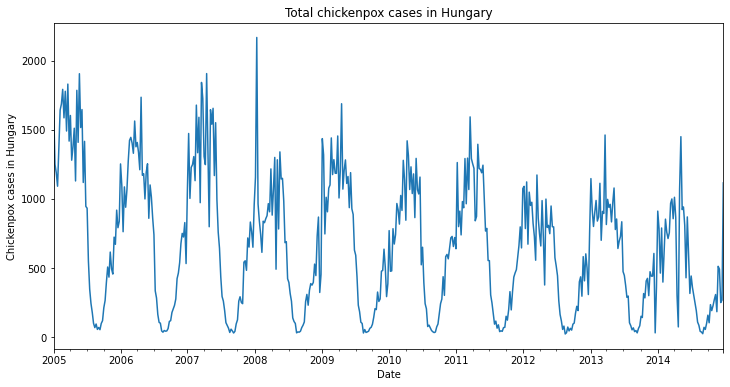

In [10]:
title = 'Total chickenpox cases in Hungary'
ylabel = 'Chickenpox cases in Hungary'
xlabel = 'Date'

ax = df['Total_Cases'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Discussion: downward trend and annual oscillations have been observed.

### Treating outliers

Resampling the data with monthly frequency

In [11]:
df = df.resample('M').mean()

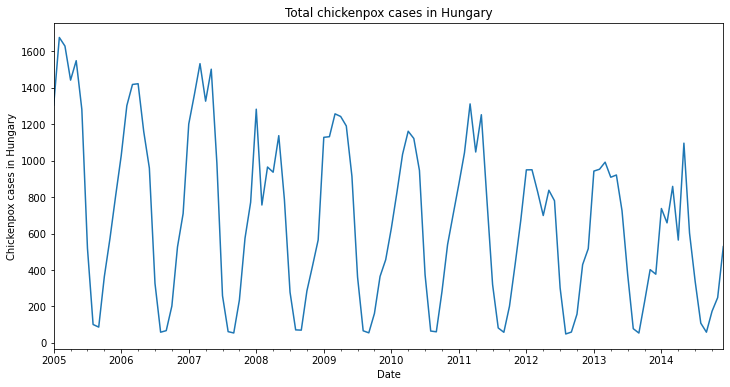

In [12]:
title = 'Total chickenpox cases in Hungary'
ylabel = 'Chickenpox cases in Hungary'
xlabel = 'Date'

ax = df['Total_Cases'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## STEP 2: Analyzing the time series

### SARIMA optimized with autoARIMA

In [13]:
# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

### Running ETS decomposition

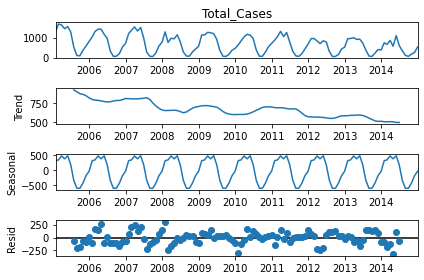

In [14]:
# decomposing the series to trend, seasonal and residual and then plotting them
result = seasonal_decompose(df['Total_Cases'], model='add')
result.plot();

### Runing pmdarima.auto_arima to obtain recommended orders

Discussion: the decomposition shows a prominent seasonal component and an unclear trend.

In [15]:
# for SARIMA orders setting seasonal=True and pass in an m value
auto_arima(df['Total_Cases'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  120
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -772.524
Date:                              Sat, 24 Jul 2021   AIC                           1555.049
Time:                                      15:56:34   BIC                           1568.986
Sample:                                           0   HQIC                          1560.709
                                              - 120                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.2172      5.183      1.007      0.314      -4.941      15.375
ar.L1          0.6668      0.074      9.038      0.000       0.522       0.811
ar.S.L12       0.9776      0.017     56.350      0.000       0.944       1.012
ma.S.L12      -0.6130      0.143     -4.277      0.000      -0.894      -0.332
sigma2      1.893e+04   1435.883     13.185      0.000    1.61e+04    2.17e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.65   Jarque-Bera (JB):               109.50
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.97
Prob(H) (two-sided):                  0.03   Kurtosis:                         7.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This provides an ARIMA Order of (1,0,0) combined with a seasonal order of (1,0,1,12) Now let's train & test the SARIMA(1,0,0)(1,0,1,12) model, evaluate it, then produce a forecast of future values.

### Splitting the data into train/test sets

In [16]:
len(df)

120

In [17]:
# setting one year for testing
train = df.iloc[:109]
test = df.iloc[109:]

In [18]:
# fitting SARIMA(1,0,0)(1,0,1,12) model
model = SARIMAX(train['Total_Cases'],order=(1,0,0),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          Total_Cases   No. Observations:                  109
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -701.673
Date:                              Sat, 24 Jul 2021   AIC                           1411.347
Time:                                      15:58:31   BIC                           1422.112
Sample:                                  01-31-2005   HQIC                          1415.713
                                       - 01-31-2014                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7908      0.043     18.262      0.000       0.706       0.876
ar.S.L12       0.9925      0.010     95.191      0.000       0.972       1.013
ma.S.L12      -0.7415      0.176     -4.220      0.000      -1.086      -0.397
sigma2       1.75e+04   1493.187     11.722      0.000    1.46e+04    2.04e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):               207.43
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -1.35
Prob(H) (two-sided):                  0.17   Kurtosis:                         9.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# obtaining predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,0,0)(1,0,1,12) Predictions')

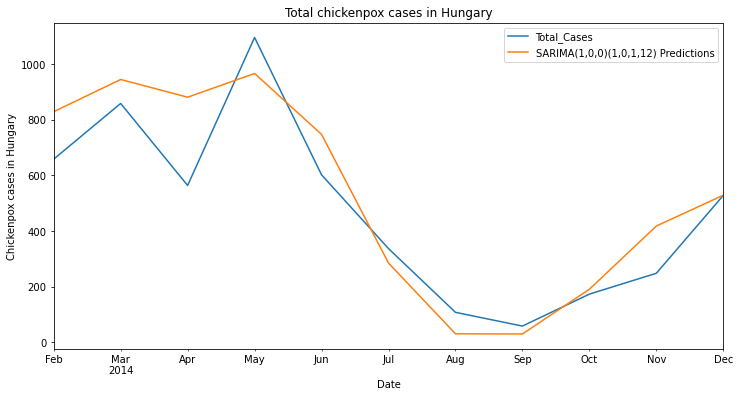

In [21]:
# plotting predictions against known values
title = 'Total chickenpox cases in Hungary'
ylabel = 'Chickenpox cases in Hungary'
xlabel = 'Date'

ax = test['Total_Cases'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Evaluating the model

In [22]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Total_Cases'], predictions)
print(f'SARIMA(1,0,0)(1,0,1,12) MSE Error: {error:11.10}')

SARIMA(1,0,0)(1,0,1,12) MSE Error: 19428.21541


In [23]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Total_Cases'], predictions)
print(f'SARIMA(1,0,0)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(1,0,0)(1,0,1,12) RMSE Error: 139.3851334


Discussion: the high prediction errors might be explained by the fact that the predicted year differs from two previous by two spikes, downward-facing and upward-facing, in April and May 2014.

## STEP 3: Prediction

### Retraining the model on the full data, and forecasting the future

In [26]:
model = SARIMAX(df['Total_Cases'],order=(1,0,0),seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(1,0,0)(1,0,1,12) Forecast')

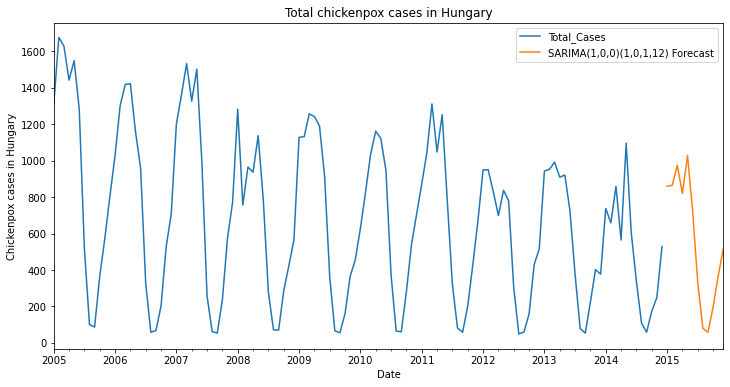

In [27]:
# plotting predictions against known values
title = 'Total chickenpox cases in Hungary'
ylabel = 'Chickenpox cases in Hungary'
xlabel = 'Date'

ax = df['Total_Cases'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Summary: SARIMA(1,0,0)(1,0,1,12) has reasonably repeated the time series pattern after interpolating from weekly to monthly sampling.